## Modules

In [9]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard
from __future__ import print_function
from IPython.display import SVG, Image
from keras import regularizers
from matplotlib import rc

import keras
import matplotlib.pyplot as plt
import numpy as np
# import graphviz

In [8]:
%matplotlib inline
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 20}

rc('font', **font)

## Global Variables

The number of classes, the input dimension and the batch size are constant.

In [4]:
num_classes = 10
input_dim = 784
batch_size = 256

## Data import and preprocessing

All data is normalized and serialized into a vector.

In [5]:
(x_train, y_train), (x_val, y_val) = mnist.load_data()
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [5]:
(x_train, y_train), (x_val, y_val) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))
print(x_train.shape)

(60000, 784)


In [6]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

# Train Neural Net to recognize MNIST digits

In [ ]:
# constants
hidden1_dim = 512
hidden2_dim = 512

`Dropout` consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.

In [8]:
input_data = Input(shape=(input_dim,), dtype='float32', name='main_input')
x = Dense(hidden1_dim, activation='relu', kernel_initializer='normal')(input_data)
x = Dropout(0.2)(x)
x = Dense(hidden2_dim, activation='relu', kernel_initializer='normal')(x)
x = Dropout(0.2)(x)
output_layer = Dense(num_classes, activation='softmax', kernel_initializer='normal')(x)

model = Model(input_data, output_layer)

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

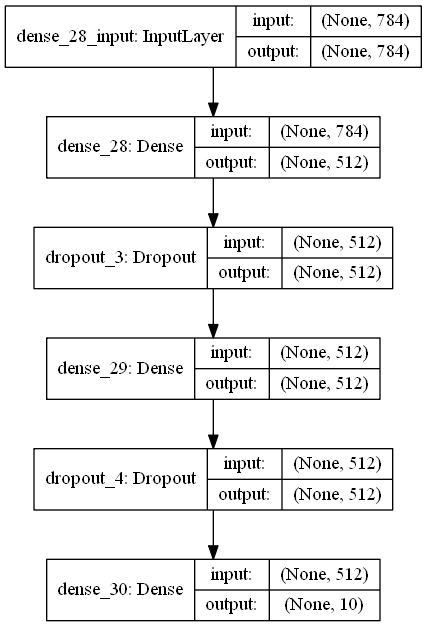

In [9]:
Image("images/mnist_nn1.png")

In [10]:
model.fit(x_train, y_train, 
           batch_size=batch_size,
           epochs=20,
           verbose=0,
           validation_split=0.1)

In [11]:
score = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0821917162947
Test accuracy: 0.9837


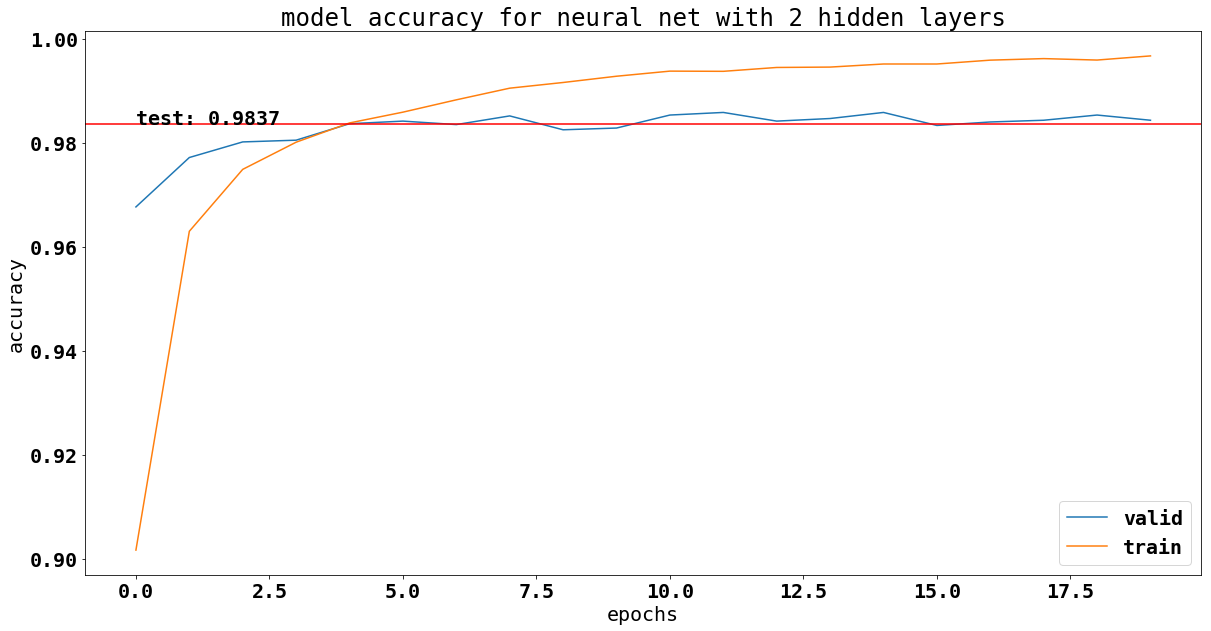

In [12]:
fig = plt.figure(figsize=(20,10))
plt.plot(model.history.history['val_acc'])
plt.plot(model.history.history['acc'])
plt.axhline(y=score[1], c="red")
plt.text(0, score[1], "test: " + str(round(score[1], 4)), fontdict=font)
plt.title('model accuracy for neural net with 2 hidden layers')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['valid', 'train'], loc='lower right')
plt.show()

# Single autoencoder

## Model Definitions

Using keras module with compression to 32 floats.

In [13]:
encoding_dim = 32

In [14]:
# input placeholder
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

single_autoencoder = Model(input_img, decoded)

Encoder Model:

In [15]:
# this model maps an input to its encoded representation
single_encoder = Model(input_img, encoded)

Decoder Model:

In [16]:
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = single_autoencoder.layers[-1]
# create the decoder model
single_decoder = Model(encoded_input, decoder_layer(encoded_input))

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the RMSprop optimizer:

Binary Cross Entropy = Binomial Cross Entropy = Special Case of Multinomial Cross Entropy 

In [17]:
single_autoencoder.compile(optimizer=RMSprop(), loss='binary_crossentropy')

### Train/load model

In [18]:
# single_autoencoder = keras.models.load_model('models/single_autoencoder.h5')
single_autoencoder.fit(x_train, x_train,
                       epochs=50,
                       batch_size=batch_size,
                       shuffle=False,
                       verbose=0,
                       validation_split=0.1,
                       callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

In [19]:
# single_autoencoder.save('models/single_autoencoder.h5')

In [20]:
score = single_autoencoder.evaluate(x_val, x_val, verbose=0)
print(score)

0.0952733350277


In [21]:
# plot_model(single_autoencoder, to_file='images/single_autoencoder.png', show_shapes=True, show_layer_names=True, rankdir='LR')

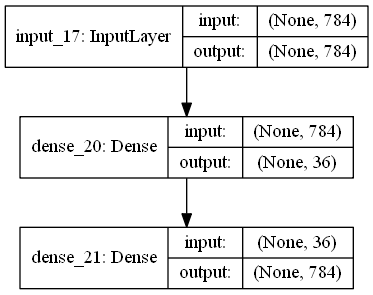

In [22]:
Image("images/single_autoencoder.png")

After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about {{score}}. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [23]:
encoded_imgs = single_encoder.predict(x_val)
# decoded_imgs = single_decoder.predict(encoded_imgs)
decoded_imgs = single_autoencoder.predict(x_val)

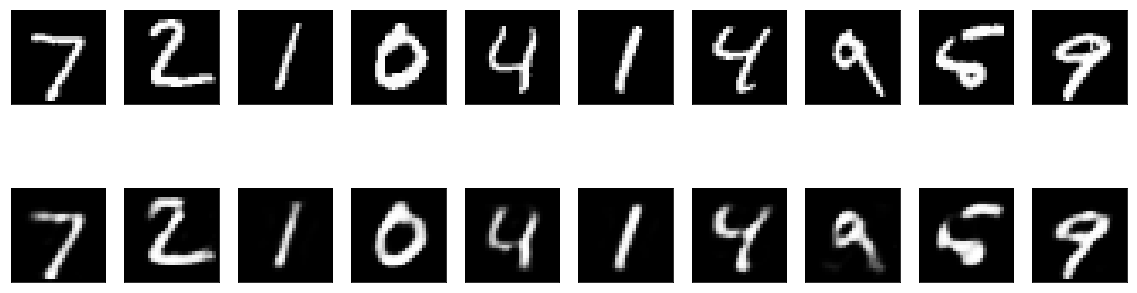

In [24]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Stacked Autoencoder

In [25]:
######## constants for stacked autoencoder ############
encoding_dim1 = 128
encoding_dim2 = 64
encoding_dim3 = 32
decoding_dim1 = 64
decoding_dim2 = 128
decoding_dim3 = input_dim
epochs = 100
batch_size = 256

In [26]:
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim1, activation='relu')(input_img)
encoded = Dense(encoding_dim2, activation='relu')(encoded)
encoded = Dense(encoding_dim3, activation='relu')(encoded)

decoded = Dense(decoding_dim1, activation='relu')(encoded)
decoded = Dense(decoding_dim2, activation='relu')(decoded)
decoded = Dense(decoding_dim3, activation='sigmoid')(decoded)

In [27]:
stacked_autoencoder = Model(input_img, decoded)
stacked_autoencoder.compile(optimizer=RMSprop(), loss='binary_crossentropy')

In [28]:
stacked_autoencoder = keras.models.load_model('models/stacked_autoencoder.h5')
#stacked_autoencoder.fit(x_train, x_train,
#                 epochs=epochs,
#                 batch_size=batch_size,
#                 shuffle=False,
#                 validation_split=0.1)

Save the model

In [29]:
# stacked_autoencoder.save('models/stacked_autoencoder.h5')

In [30]:
score = stacked_autoencoder.evaluate(x_val, x_val, verbose=0)
print(score)

0.11782884047


The result is slightly better than for single autoencoder.

In [31]:
# plot_model(stacked_autoencoder, to_file='images/stacked_autoencoderTD.png', show_shapes=True, show_layer_names=True, rankdir='LR')

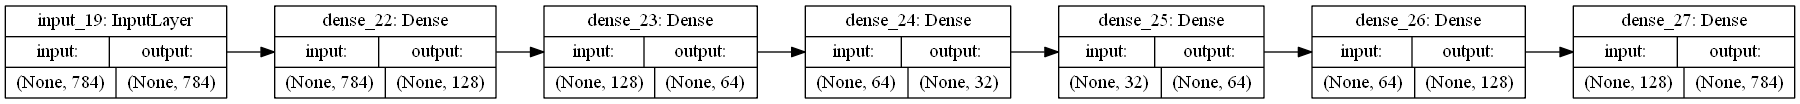

In [32]:
Image("images/stacked_autoencoderTD.png")

In [33]:
decoded_imgs = stacked_autoencoder.predict(x_val)

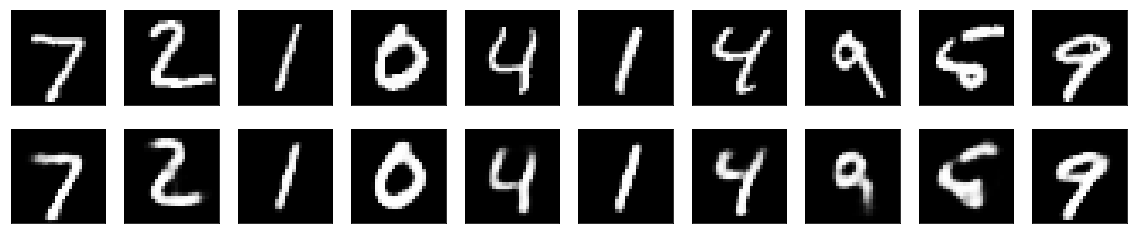

In [34]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Denoising Data

In [35]:
noise_factor = 0.5

In [36]:
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 

# re-normalization by clipping to the intervall (0,1)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)

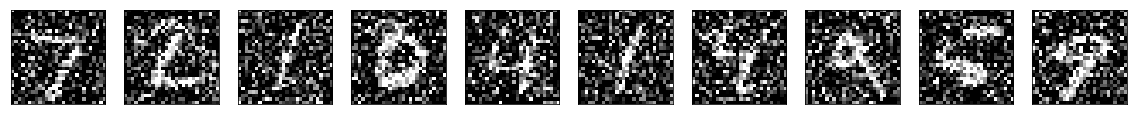

In [37]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_val_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Stick with the stack

In [38]:
denoising_autoencoder = Model(input_img, decoded)
denoising_autoencoder.compile(optimizer=RMSprop(), loss='binary_crossentropy')

### Train or load a stacked denoising autoencoder

In [39]:
# denoising_autoencoder = keras.models.load_model('models/denoising_autoencoder.h5')
denoising_autoencoder.fit(x_train_noisy, x_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_split=0.1,
                          verbose=0,
                          callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

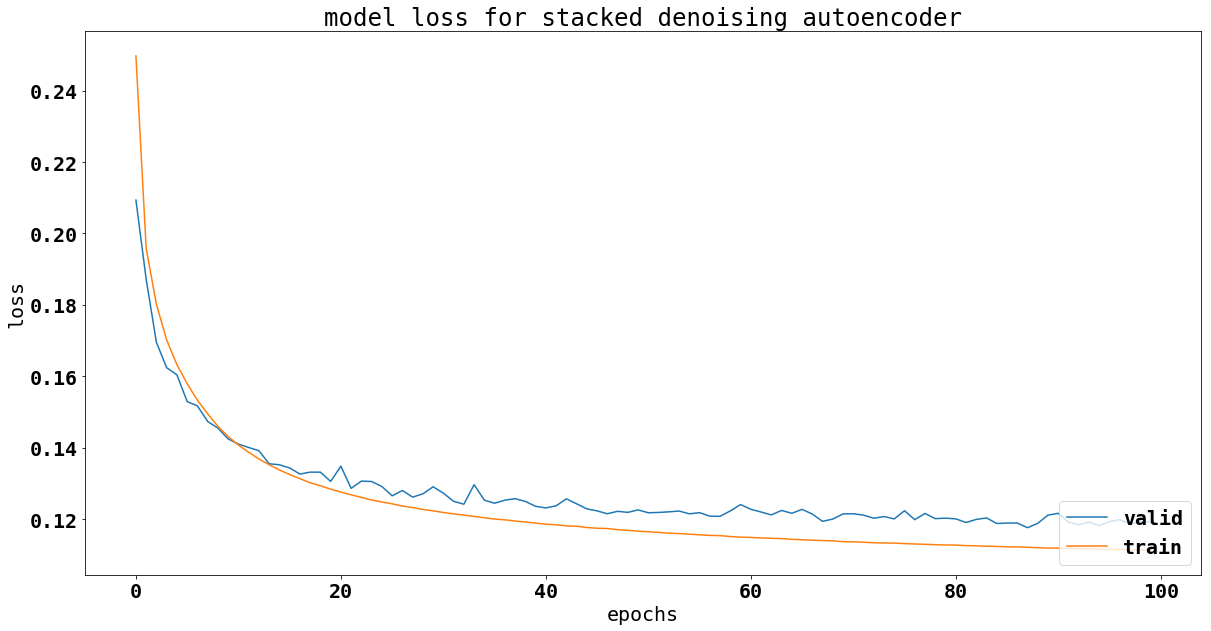

In [40]:
fig = plt.figure(figsize=(20,10))
plt.plot(denoising_autoencoder.history.history['val_loss'])
plt.plot(denoising_autoencoder.history.history['loss'])
plt.title('model loss for stacked denoising autoencoder')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['valid', 'train'], loc='lower right')
plt.show()

In [41]:
decoded_imgs = denoising_autoencoder.predict(x_val_noisy)

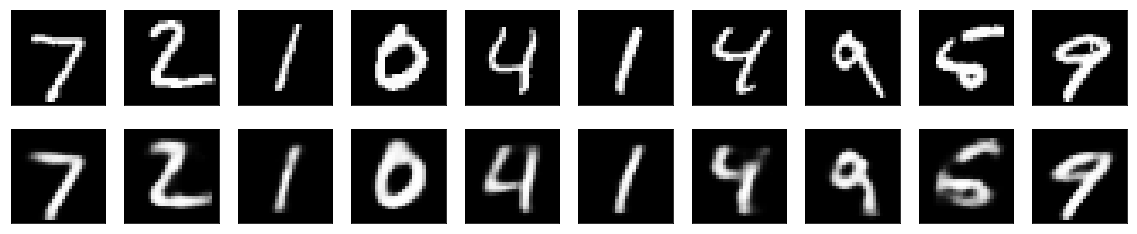

In [42]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Compare results

## Classification of noisy data

In [43]:
score = model.evaluate(x_val_noisy, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 6.02027354736
Test accuracy: 0.4772


## Classification of denoised data

In [44]:
score = model.evaluate(decoded_imgs, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.402161158466
Test accuracy: 0.9395


The difference in accuracy is huge. The autoencoder architecture is highly recommendable for denoising signals.

# Train with sparsity constraint on hidden layer (not for presentation)

So what does all this mean for sparsity? How does the rectifier activation function allow for sparsity in the hidden units? If the hidden units are exposed to a range of input values it makes sense that the rectifier activation function should lead to more ‘real zeros’ as we sweep across possible inputs. In other words, less neurons in our network would activate because of the limitations imposed by the rectifier activation function. https://www.quora.com/What-does-it-mean-that-activation-functions-like-ReLUs-in-NNs-induce-sparsity-in-the-hidden-units

In [213]:
input_img = Input(shape=(input_dim,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

sparse_autoencoder = Model(input_img, decoded)

sparse_encoder = Model(input_img, encoded)

In [214]:
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = sparse_autoencoder.layers[-1]
# create the decoder model
sparse_decoder = Model(encoded_input, decoder_layer(encoded_input))

Sparse Autoencoder

In [215]:
sparse_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [15]:
sparse_autoencoder = keras.models.load_model('models/sparse_autoencoder.h5')
sparse_autoencoder.fit(x_train, x_train, 
                       epochs=20,
                       batch_size=batch_size,
                       validation_data=(x_val, x_val),
                       callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

In [180]:
# sparse_autoencoder.save('models/sparse_autoencoder.h5')

In [16]:
score = sparse_autoencoder.evaluate(x_val, x_val, verbose=0)
print(score)

0.271617044735


In [219]:
encoded_imgs = sparse_encoder.predict(x_val)
# decoded_imgs = single_decoder.predict(encoded_imgs)
decoded_imgs = sparse_decoder.predict(encoded_imgs)

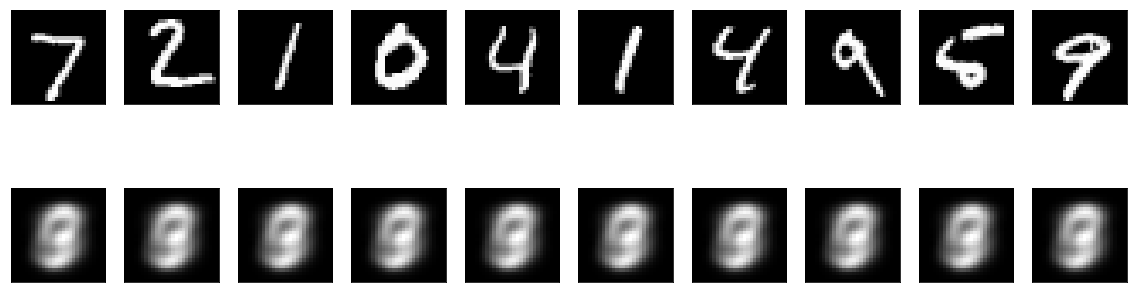

In [220]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [184]:
encoded_imgs.mean()

1.5224896e-06

## Test the Vanilla Autoencoder with a simple Neural Net (not for presentation)

In [93]:
single_ae_test_model = Sequential()
# single_ae_test_model.add(Dense(16, activation='relu', input_shape=(36,)))
# single_ae_test_model.add(Dropout(0.2))
single_ae_test_model.add(Dense(num_classes, activation='softmax', input_shape=(encoding_dim,)))

In [94]:
single_ae_test_model.compile(loss='categorical_crossentropy',
                             optimizer=RMSprop(),
                             metrics=['accuracy'])

In [95]:
single_ae_test_model = keras.models.load_model('models/single_ae_test_model.h5')
# single_ae_test_model.fit(single_encoder.predict(x_train), y_train, 
#                          batch_size=batch_size,
#                          epochs=40,
#                          verbose=1,
#                          validation_data=(single_encoder.predict(x_val), y_val))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 1s 19us/step - loss: 2.0940 - acc: 0.3325 - val_loss: 1.9131 - val_acc: 0.4895
Epoch 2/40
60000/60000 [==============================] - 1s 9us/step - loss: 1.7834 - acc: 0.5378 - val_loss: 1.6415 - val_acc: 0.5859
Epoch 3/40
60000/60000 [==============================] - 1s 9us/step - loss: 1.5601 - acc: 0.5982 - val_loss: 1.4475 - val_acc: 0.6314
Epoch 4/40
60000/60000 [==============================] - 1s 10us/step - loss: 1.4011 - acc: 0.6275 - val_loss: 1.3102 - val_acc: 0.6533
Epoch 5/40
60000/60000 [==============================] - 1s 10us/step - loss: 1.2877 - acc: 0.6452 - val_loss: 1.2109 - val_acc: 0.6667
Epoch 6/40
60000/60000 [==============================] - 1s 9us/step - loss: 1.2065 - acc: 0.6582 - val_loss: 1.1393 - val_acc: 0.6766
Epoch 7/40
60000/60000 [==============================] - 1s 8us/step - loss: 1.1468 - acc: 0.6671 - val_loss: 1.0858 - val_acc: 0.

In [96]:
single_ae_test_model.save('models/single_ae_test_model.h5')

In [36]:
score = single_ae_test_model.evaluate(single_encoder.predict(x_val), y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.867385588598
Test accuracy: 0.7292


## Test the Sparse Autoencoder with a simple Neural Net (not for presentation)

In [185]:
sparse_ae_test_model = Sequential()
# single_ae_test_model.add(Dense(16, activation='relu', input_shape=(36,)))
# single_ae_test_model.add(Dropout(0.2))
sparse_ae_test_model.add(Dense(num_classes, activation='softmax', input_shape=(encoding_dim,)))

In [186]:
sparse_ae_test_model.compile(loss='categorical_crossentropy',
                             optimizer=RMSprop(),
                             metrics=['accuracy'])

In [187]:
# sparse_ae_test_model = keras.models.load_model('models/sparse_ae_test_model.h5')
sparse_ae_test_model.fit(sparse_encoder.predict(x_train), y_train, 
                         batch_size=batch_size,
                         epochs=40,
                         verbose=1,
                         validation_data=(sparse_encoder.predict(x_val), y_val))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 1s 23us/step - loss: 2.3018 - acc: 0.1112 - val_loss: 2.3012 - val_acc: 0.1135
Epoch 2/40
60000/60000 [==============================] - 1s 11us/step - loss: 2.3013 - acc: 0.1124 - val_loss: 2.3011 - val_acc: 0.1135
Epoch 3/40
60000/60000 [==============================] - 1s 11us/step - loss: 2.3012 - acc: 0.1124 - val_loss: 2.3010 - val_acc: 0.1135
Epoch 4/40
60000/60000 [==============================] - 1s 12us/step - loss: 2.3012 - acc: 0.1124 - val_loss: 2.3010 - val_acc: 0.1135
Epoch 5/40
60000/60000 [==============================] - 1s 11us/step - loss: 2.3012 - acc: 0.1124 - val_loss: 2.3010 - val_acc: 0.1135
Epoch 6/40
60000/60000 [==============================] - 1s 12us/step - loss: 2.3012 - acc: 0.1124 - val_loss: 2.3010 - val_acc: 0.1135
Epoch 7/40
60000/60000 [==============================] - 1s 11us/step - loss: 2.3012 - acc: 0.1124 - val_loss: 2.3010 - val_acc

In [96]:
sparse_ae_test_model.save('models/sparse_ae_test_model.h5')

In [36]:
score = sparse_ae_test_model.evaluate(sparse_encoder.predict(x_val), y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.867385588598
Test accuracy: 0.7292


# Additional Information and Footage

## Cross Entropy

![Cross Entropy](images\2017-12-03 10_42_19-Machine Learning_ Should I use a categorical cross entropy or binary cross entro.png)

## Batch Size

Batch size defines number of samples that going to be propagated through the network.

For instance, let's say you have 1050 training samples and you want to set up batch_size equal to 100. Algorithm takes first 100 samples (from 1st to 100th) from the training dataset and trains network. Next it takes second 100 samples (from 101st to 200th) and train network again. We can keep doing this procedure until we will propagate through the networks all samples. The problem usually happens with the last set of samples. In our example we've used 1050 which is not divisible by 100 without remainder. The simplest solution is just to get final 50 samples and train the network.

Advantages:

* It requires less memory. Since you train network using less number of samples the overall training procedure requires less memory. It's especially important in case if you are not able to fit dataset in memory.
* Typically networks trains faster with mini-batches. That's because we update weights after each propagation. In our example we've propagated 11 batches (10 of them had 100 samples and 1 had 50 samples) and after each of them we've updated network's parameters. If we used all samples during propagation we would make only 1 update for the network's parameter.

Disadvantages:

* The smaller the batch the less accurate estimate of the gradient. In the figure below you can see that mini-batch (green color) gradient's direction fluctuates compare to the full batch (blue color).

![https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network](images\lU3sx.png)

to be done:
- check various encoders with different numbers of hidden layers
- feature extraction

# Dropout

Deep neural nets with a large number of parameters are very powerful machine learning
systems. However, overfitting is a serious problem in such networks. Large networks are also
slow to use, making it difficult to deal with overfitting by combining the predictions of many
different large neural nets at test time. Dropout is a technique for addressing this problem.
The key idea is to randomly drop units (along with their connections) from the neural
network during training. This prevents units from co-adapting too much. During training,
dropout samples from an exponential number of different “thinned” networks. At test time,
it is easy to approximate the effect of averaging the predictions of all these thinned networks
by simply using a single unthinned network that has smaller weights. This significantly
reduces overfitting and gives major improvements over other regularization methods. We
show that dropout improves the performance of neural networks on supervised learning
tasks in vision, speech recognition, document classification and computational biology,
obtaining state-of-the-art results on many benchmark data sets.

For more information on dropout visit http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf